In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import datasets,transforms
from torch.utils.data import DataLoader
from torch.optim import SGD
import shutil
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [5]:
dataset_path = '/content/drive/MyDrive/dataset'
train_path = '/content/drive/MyDrive/dataset/train_dataset'
test_path = '/content/drive/MyDrive/dataset/train_dataset'

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
#transformation for dataset

transform = transforms.Compose([transforms.Resize((299,299)),transforms.ToTensor()])

In [8]:
dataset = datasets.ImageFolder(dataset_path,transform = transform)

In [9]:
dataloader = DataLoader(dataset,batch_size = 32,shuffle = True)

In [10]:
dataitem = iter(dataloader)
images,label = next(dataitem)

In [14]:
#mean and standard deviation calculation
batch_size = 32
m = torch.zeros(3)
std = torch.zeros(3)
n=0
for images,_ in dataloader:
    batch_sample = images.size(0)
    n += batch_sample
    m += images.mean(dim=(0,2,3))*batch_sample
    std += images.std(dim = (0,2,3))*batch_sample

m = m/n
std = std/n
m,std

(tensor([0.7194, 0.7180, 0.6539]), tensor([0.2366, 0.2363, 0.3226]))

In [15]:
#train transform and test transform
train_transform = transforms.Compose([transforms.Resize((299,299)),
                                     transforms.RandomRotation(15),
                                     transforms.RandomHorizontalFlip(0.3),
                                     transforms.RandomVerticalFlip(0.3),
                                     transforms.ColorJitter(brightness = 0.2,contrast = 0.2,saturation = 0.2),
                                     transforms.ToTensor(),
                                     transforms.Normalize(m,std)])

test_transform = transforms.Compose([transforms.Resize((299,299)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(m,std)])

In [16]:
train_dataset = datasets.ImageFolder(train_path,transform = train_transform)
test_dataset = datasets.ImageFolder(test_path,transform = test_transform)

In [17]:
train_loader = DataLoader(train_dataset,batch_size = 16,shuffle = True)
test_loader = DataLoader(test_dataset,batch_size = 16,shuffle = True)

In [18]:
class_mango = []
for v,i in train_dataset.class_to_idx.items():  # Use .items() for dictionary
    class_mango.append(v)
class_mango

['Ashshina Zhinuk',
 'Bari -11',
 'Chausa',
 'Fazli',
 'Gourmati',
 'Harivanga',
 'Harumanis',
 'Katimon',
 'Langra']

In [19]:
dataitem = iter(train_loader)
images,labels = next(dataitem)

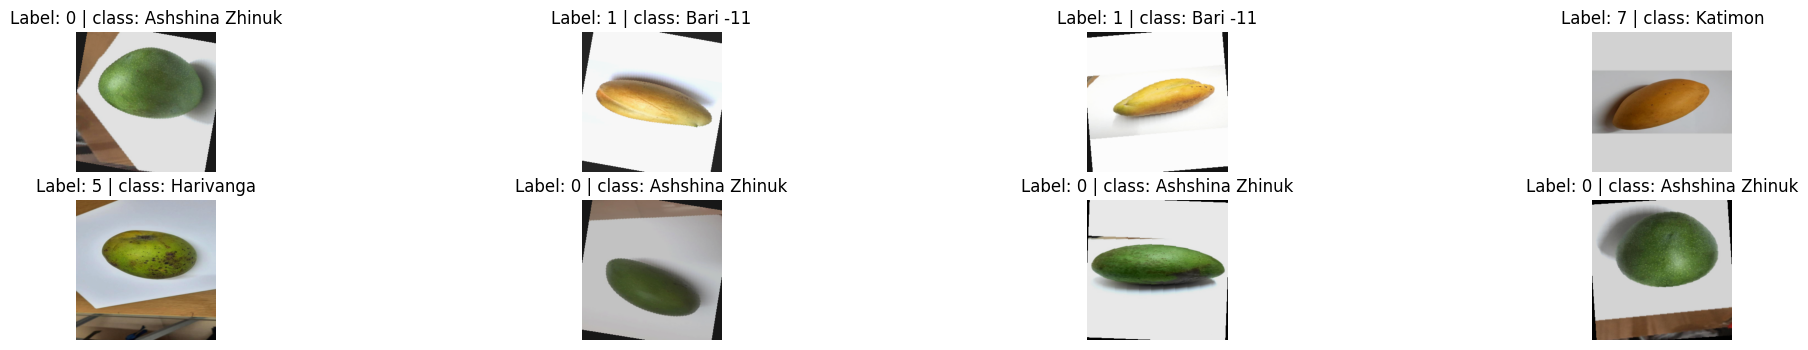

In [21]:
def denormalize(img,m,std):
    m = m[:,None,None]
    std = std[:,None,None]
    return (img*std)+m

fig,axes = plt.subplots(2,4,figsize = (25,4))
c = 0
for i in range (2):
    for j in range(4):
        img = denormalize(images[c],m,std)
        img = np.clip(img,0,1)
        axes[i][j].imshow(img.permute(1,2,0).numpy())
        axes[i][j].axis('off')
        axes[i][j].set_title(f'Label: {labels[c]} | class: {class_mango[labels[c]]}')
        c+=1
plt.show()

In [24]:
#create an instance for Network
#model = Network().to(device)
model = models.inception_v3(pretrained = True).to(device)
model.fc = nn.Linear(2048,9)
model = model.to(device)
#Instance for a loss function

criteria = nn.CrossEntropyLoss()

#Instance for a Optimizer function

optimizer = SGD(model.parameters(),lr = 0.001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


For epoch: 1 train loss: 1.3881424509343647 test loss: 1.095228244009472
For epoch: 2 train loss: 0.9466420762595676 test loss: 0.6830580701430639
For epoch: 3 train loss: 0.6672856478464035 test loss: 0.43208425009534474
For epoch: 4 train loss: 0.5122111723536537 test loss: 0.28992937122072493
For epoch: 5 train loss: 0.40546884721233734 test loss: 0.1991992269243513
For epoch: 6 train loss: 0.32121475771779107 test loss: 0.14464527113097056
For epoch: 7 train loss: 0.28817157470399424 test loss: 0.10507178797076146
For epoch: 8 train loss: 0.2432923011304367 test loss: 0.08179893340205863
For epoch: 9 train loss: 0.22071055400939216 test loss: 0.0651273537870674
For epoch: 10 train loss: 0.19703267898765348 test loss: 0.05169750495503346
For epoch: 11 train loss: 0.17249273977996338 test loss: 0.042221133388756285
For epoch: 12 train loss: 0.16969513148956356 test loss: 0.03979958138827767
For epoch: 13 train loss: 0.141265319252298 test loss: 0.029467730760751737
For epoch: 14 trai

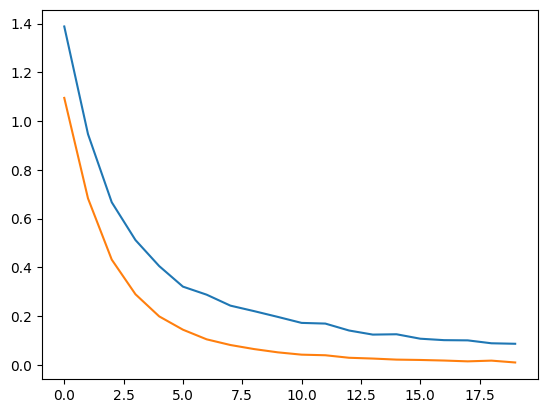

In [30]:
epochs = 20
train_loss_list = []
test_loss_list = []

for epoch in range(epochs):
    running_loss = 0
    test_loss = 0

    model.train()

    for images,labels in train_loader:

        images,labels = images.to(device),labels.to(device)

        #getting the ouputs form the model
        output,_  = model(images)

        #calculating Loss
        loss= criteria(output,labels)

        #turning previous gradients to zero
        optimizer.zero_grad()

        #backpropogating to calculate gradient
        loss.backward()

        #taking step for optimization
        optimizer.step()

        running_loss +=loss.item()
    running_loss /=len(train_loader)
    train_loss_list.append(running_loss)

    model.eval()

    for images,labels in test_loader:

        images,labels = images.to(device),labels.to(device)

        output = model(images)

        loss = criteria(output,labels)

        test_loss += loss.item()
    test_loss /=len(test_loader)
    test_loss_list.append(test_loss)
    print(f"For epoch: {epoch+1} train loss: {running_loss} test loss: {test_loss}")

correct = 0
total = 0
with torch.no_grad():
    model.eval()
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"The accuracy of model is: {accuracy}%")

plt.plot(range(epochs),train_loss_list)
plt.plot(range(epochs),test_loss_list)

In [32]:
torch.save(model.state_dict(),'model.pth')

In [40]:
images,labels = next(iter(test_loader))

Text(0.5, 1.0, 'Label: 2 | class: Chausa')

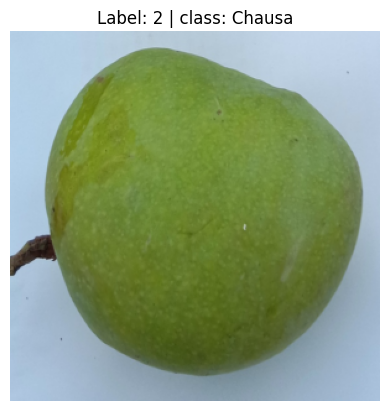

In [54]:
img = denormalize(images[11],m,std)
img = np.clip(img,0,1)
plt.imshow(img.permute(1,2,0))
plt.axis('off')
plt.title(f'Label: {labels[11]} | class: {class_mango[labels[11]]}')

In [67]:
model.eval()

with torch.no_grad():
  output = model(img.unsqueeze(0).to(device))
  output = F.softmax(output,dim=1)
output

tensor([[6.4044e-04, 4.4898e-04, 9.9279e-01, 2.0085e-03, 1.9121e-04, 2.3456e-04,
         2.6328e-04, 4.4622e-04, 2.9739e-03]], device='cuda:0')

([0, 1, 2, 3, 4, 5, 6, 7, 8],
 [Text(0, 0, 'Ashshina Zhinuk'),
  Text(1, 0, 'Bari -11'),
  Text(2, 0, 'Chausa'),
  Text(3, 0, 'Fazli'),
  Text(4, 0, 'Gourmati'),
  Text(5, 0, 'Harivanga'),
  Text(6, 0, 'Harumanis'),
  Text(7, 0, 'Katimon'),
  Text(8, 0, 'Langra')])

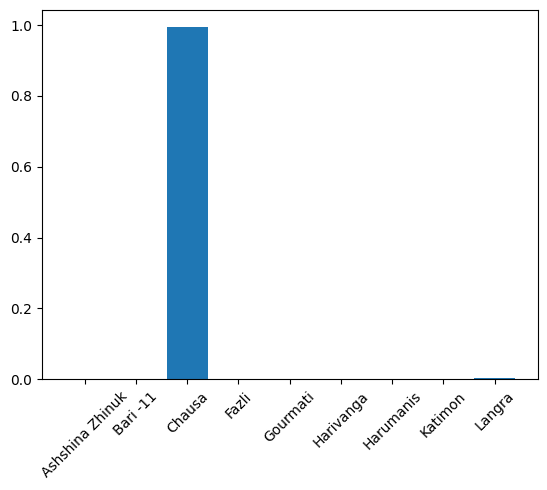

In [68]:
plt.bar(class_mango,output.cpu().numpy()[0])
plt.xticks(rotation = 45)